In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

In [3]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [4]:
from sklearn import model_selection
from sklearn.metrics import accuracy_score

In [5]:
#import training data
PG_train = pd.read_csv("train_V2.csv")

In [6]:
print(f'There are {PG_train.shape[0]} samples and {PG_train.shape[1]} features in the training PUBG V2 dataset.')

There are 4446966 samples and 29 features in the training PUBG V2 dataset.


In [7]:
pd.set_option('display.max_columns', None)
PG_train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [41]:
PG_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


In [8]:
#I want to see the relationship between maxPlace, the true ranking from 1-100, with damageDealt.
#In other words, do you get better ranking if you deal more damage, and logically, by getting in fights?
data = []
for asset in np.random.choice(PG_train['Id'].unique(), 200):
    asset_df = PG_train[(PG_train['Id'] == asset)]

    data.append(go.Scatter(
        x = asset_df['damageDealt'].values,
        y = asset_df['maxPlace'].values,
        name = asset,
        showlegend=False
    ))
layout = go.Layout(dict(title = "Killing is Winning?",
                  xaxis = dict(title = 'Damage (Higher is Better)'),
                  yaxis = dict(title = 'Rank (Lower is Better)'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

The reality is that there's no real relationship between damageDealt and final place. This is because the max value in maxPlace differs per matchType.

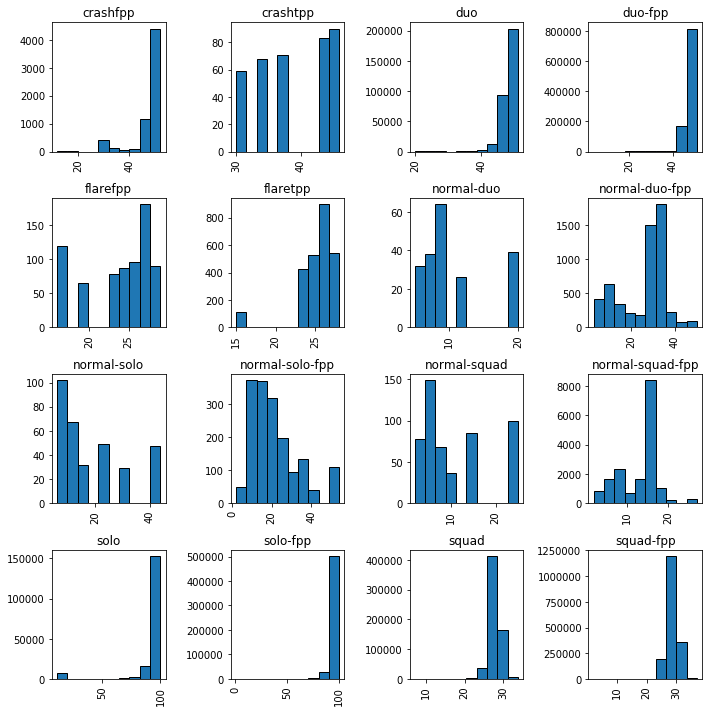

In [9]:
fig = PG_train['maxPlace'].hist(by=PG_train['matchType'],figsize=(10,10),ec="k")
plt.tight_layout()

Those histograms are interesting to bear in mind. Obviously, the distributions depend on how the data was collected: why is that important? because Ids (players) are picked randomly across 1000s of games, while in a single game everyone get one and unique place/ranking - though they might have more or less killPoints. What matters however is the place (maxPlace) at the end of the game.

In [10]:
PG_train["matchType"].value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536762
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

Looking at the distribution of the different matchType variable. I might remove all the ones under 'solo' as they represent very little to the total. With this said, I might make separate training models for them after the main types.

In [11]:
PG_train.groupby(['matchType'], sort=False)['maxPlace'].max()

matchType
squad-fpp            37
duo                  51
solo-fpp            100
squad                34
duo-fpp              51
solo                100
normal-squad-fpp     27
crashfpp             52
flaretpp             28
normal-solo-fpp      54
flarefpp             29
normal-duo-fpp       50
normal-duo           20
normal-squad         25
crashtpp             46
normal-solo          44
Name: maxPlace, dtype: int64

The difficulty in creating one unique predictive algorithm is that game parameters are very different from one matchType to another.

I think I'll split the dataset per matchType or to simplify, split between solo, duo and squad, though squad can also be played as solo or duo. So I might train the model on squad only (squad-fpp+squad) and see if how it works for the other matchTypes. Though I could train a model across the entire dataset regardless of matchType, I can't do it at this stage because my computer can't manage it: splitting analysis by matchType might help to lower CPU usage.

In [12]:
PG_train['winPlacePerc'].nunique()

3000

In [13]:
PG_train.groupby(['winPlacePerc'], sort=False)['maxPlace'].max()

winPlacePerc
0.4444    100
0.6400     76
0.7755     99
0.1667     97
0.1875     97
0.0370     82
0.0000    100
0.7368     96
0.3704     82
0.2143     99
0.3929     85
0.4043     95
0.9286     99
0.8750     97
0.9000     91
0.2766     95
0.7308     79
0.8211     96
0.1923     79
0.9310     88
0.6383     95
0.7500     97
0.9592     99
0.9231     92
0.8696     93
0.1154     79
0.7234     95
0.9630     82
0.4255     95
0.0667     91
         ... 
0.4714     71
0.6711     77
0.3443     62
0.1148     62
0.8070     58
0.9423     53
0.6167     61
0.1311     62
0.4833     61
0.8833     61
0.1268     72
0.2687     68
0.4098     62
0.7115     53
0.2237     77
0.2742     63
0.9344     62
0.0635     64
0.0423     72
0.5915     72
0.0164     62
0.4366     72
0.9859     72
0.2167     61
0.0577     53
0.6212     67
0.0845     72
0.1207     59
0.4561     58
0.2879     67
Name: maxPlace, Length: 3000, dtype: int64

In [14]:
PG_train.groupby(['winPlacePerc'], sort=False)['maxPlace'].min()

winPlacePerc
0.4444    10
0.6400    26
0.7755    50
0.1667     7
0.1875    17
0.0370    28
0.0000     2
0.7368    20
0.3704    28
0.2143    15
0.3929    29
0.4043    48
0.9286    15
0.8750     9
0.9000    11
0.2766    48
0.7308    27
0.8211    96
0.1923    27
0.9310    30
0.6383    48
0.7500     5
0.9592    50
0.9231    14
0.8696    24
0.1154    27
0.7234    48
0.9630    28
0.4255    48
0.0667    16
          ..
0.4714    71
0.6711    77
0.3443    62
0.1148    62
0.8070    58
0.9423    53
0.6167    61
0.1311    62
0.4833    61
0.8833    61
0.1268    72
0.2687    68
0.4098    62
0.7115    53
0.2237    77
0.2742    63
0.9344    62
0.0635    64
0.0423    72
0.5915    72
0.0164    62
0.4366    72
0.9859    72
0.2167    61
0.0577    53
0.6212    67
0.0845    72
0.1207    59
0.4561    58
0.2879    67
Name: maxPlace, Length: 3000, dtype: int64

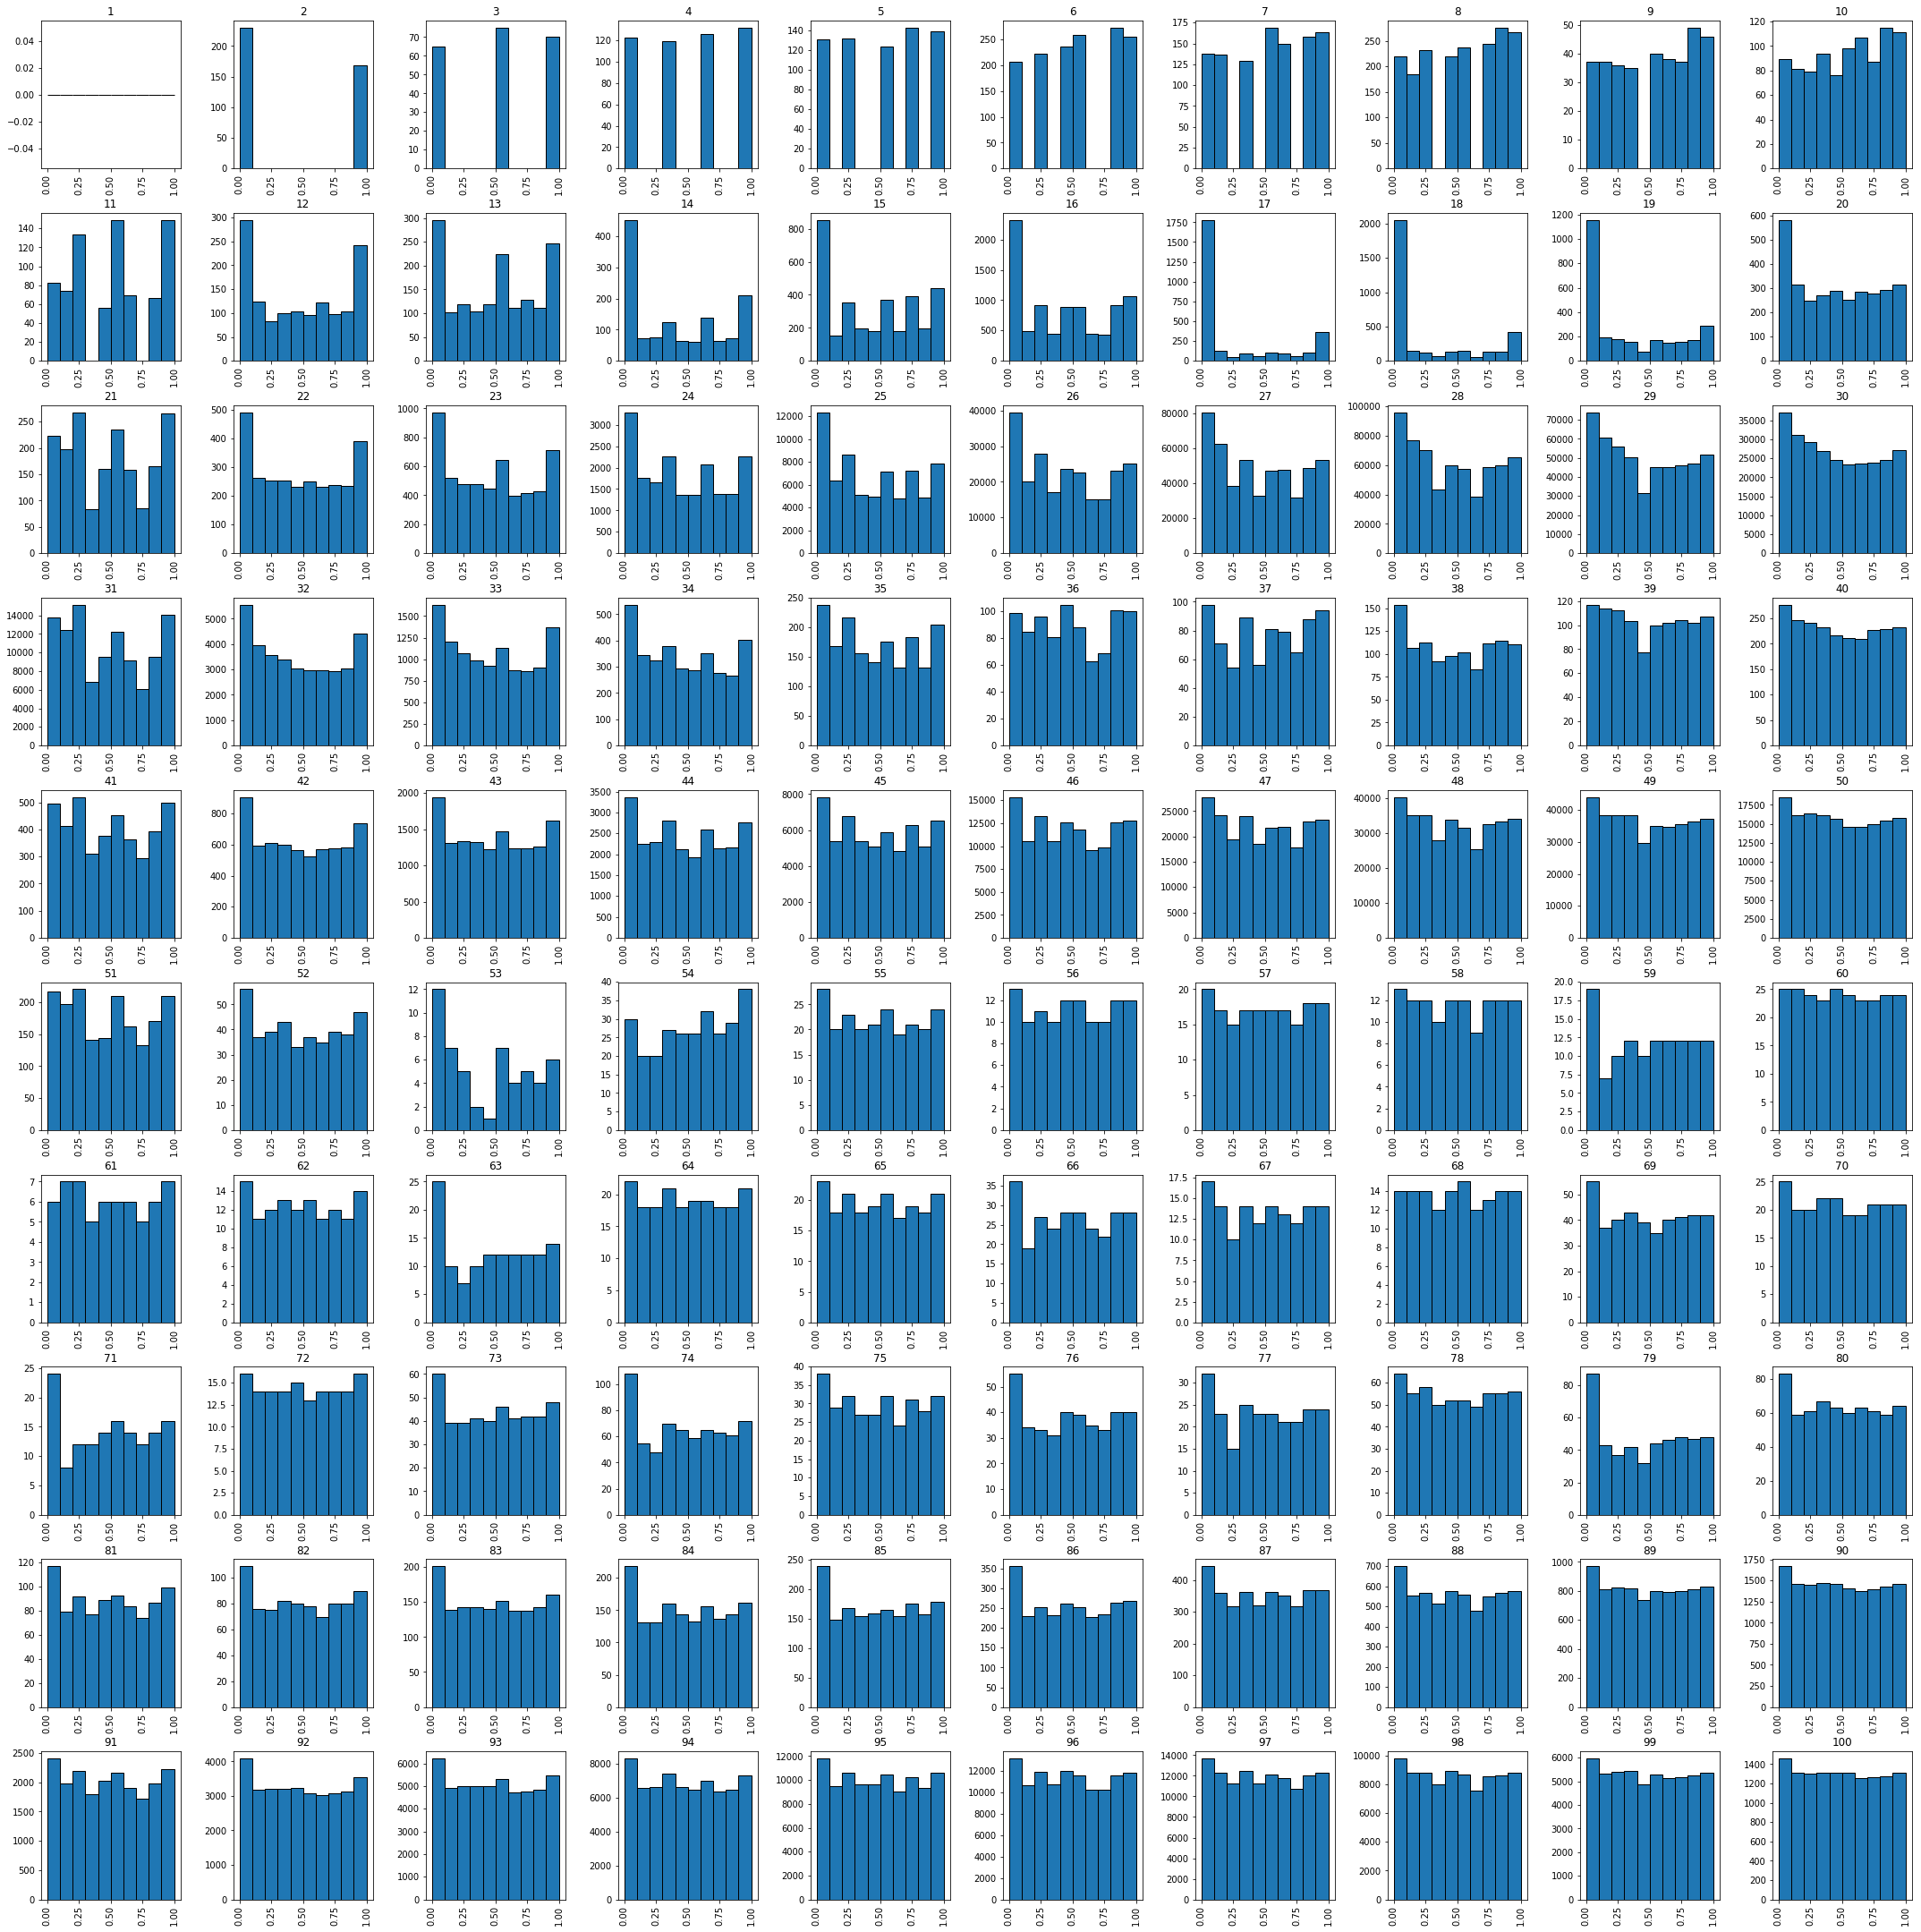

In [17]:
fig2 = PG_train['winPlacePerc'].hist(by=PG_train['maxPlace'],figsize=(30,30),ec="k")
plt.tight_layout()

In [18]:
PG_train.groupby(['winPlacePerc'], sort=False)['maxPlace'].describe()

,count,mean,std,min,25%,50%,75%,max
winPlacePerc,,,,,,,,
0.4444,23013.0,30.931952,9.884729,10.0,28.0,28.0,28.0,100.0
0.6400,7719.0,26.119834,1.947223,26.0,26.0,26.0,26.0,76.0
0.7755,3514.0,57.209163,17.359802,50.0,50.0,50.0,50.0,99.0
0.1667,16985.0,43.589932,19.245631,7.0,31.0,49.0,49.0,97.0
0.1875,9378.0,54.464705,17.036320,17.0,49.0,49.0,49.0,97.0
0.0370,28937.0,28.022393,1.052622,28.0,28.0,28.0,28.0,82.0
0.0000,220505.0,36.098256,18.191715,2.0,27.0,29.0,46.0,100.0
0.7368,1314.0,86.890411,24.176714,20.0,96.0,96.0,96.0,96.0
0.3704,21390.0,28.032819,1.278634,28.0,28.0,28.0,28.0,82.0


In [32]:
PG_train.loc[PG_train['winPlacePerc']==1]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
67,22252be49d4419,37fa7583da2fa2,1ce1cb998f75c7,1,5,378.80,2,3,6,4,0,4,2,61.390,1297,squad-fpp,29,28,1431,0,317.7,0,0.000,0,1,3120.0,4,0,1.0
107,7970b4ea89e81e,abf9e2780b9f48,04832cfd74ff30,1,1,58.36,0,0,2,38,0,0,0,0.000,1708,squad,26,25,1494,0,5134.0,0,0.000,0,0,2708.0,7,0,1.0
118,953577684b828a,54ce33c41ef9ff,c5d412db6dbee4,2,6,76.11,0,0,12,45,0,0,0,0.000,1388,duo-fpp,49,47,1468,1,0.0,0,0.000,0,0,2635.0,7,0,1.0
123,174c758156bcf3,a935604c9bb7aa,edc87c8d445823,1,9,626.20,4,3,2,4,1333,6,2,85.740,1405,squad-fpp,29,28,-1,0,1045.0,0,0.000,0,0,2814.0,7,1566,1.0
186,eb7a3e9f50eca5,fe3d74f737cd10,92338c2233be1a,0,5,778.00,0,3,2,2,1693,8,1,158.900,1387,solo-fpp,98,97,-1,0,0.0,0,0.000,0,0,2422.0,5,1506,1.0
229,de5d4078b95b3e,f31719bc7a9b81,46fef5beda2edb,2,3,629.00,4,2,1,4,0,5,2,200.200,1394,squad,29,28,1456,3,203.5,0,0.000,0,0,2697.0,4,0,1.0
300,9ac54e66c0a5d3,d973f082d6c416,15535f0f9d9e46,1,7,1120.00,8,3,1,1,0,14,3,112.500,1305,squad-fpp,31,29,1649,0,0.0,0,0.000,0,0,3503.0,8,0,1.0
341,ab4532e6427a7e,91b422b51e687f,12f3738af22f97,0,6,91.00,0,1,0,29,0,1,1,20.110,1801,duo-fpp,46,45,1552,0,4427.0,0,0.000,0,0,2348.0,4,0,1.0
396,04c098428fcf76,661280662c9ef5,da92638f46258e,0,9,235.70,0,0,5,22,1427,1,1,60.760,1814,squad,27,27,-1,3,4439.0,0,0.000,0,0,3408.0,9,1460,1.0
465,d310b194f8a869,776b1830133440,4fcbc19ac4df3d,0,4,181.50,2,0,10,7,1653,3,2,43.780,1769,squad-fpp,28,26,-1,0,3279.0,0,0.000,1,1,3202.0,6,1603,1.0


In [36]:
PG_train.groupby(['matchId'], sort=False)['Id'].describe()

,count,unique,top,freq
matchId,,,,
a10357fd1a4a91,96,96,71f354d1970316,1
aeb375fc57110c,91,91,ea6e00629df506,1
110163d8bb94ae,98,98,b3500b944899ed,1
f1f1f4ef412d7e,91,91,c134da2d41cdaa,1
6dc8ff871e21e6,97,97,c405a711cf0dc9,1
bac52627a12114,95,95,16e2ce26f6f853,1
a8274e903927a2,97,97,1db77ceab020f4,1
292611730ca862,96,96,e57aade9d9a216,1
df014fbee741c6,97,97,d40106799e9780,1


In [46]:
PG_train.loc[PG_train['walkDistance']==0].describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,99603.000000,99603.000000,99603.000000,99603.000000,99603.000000,99603.000000,99603.000000,99603.000000,99603.000000,99603.000000,99603.000000,99603.000000,99603.000000,99603.000000,99603.000000,99603.000000,99603.000000,99603.000000,99603.000000,99603.000000,99603.000000,99603.0,99603.000000,99603.000000,99602.000000
mean,0.031073,0.009719,17.646627,0.021566,0.020220,0.037228,81.892453,412.560294,0.083552,0.024357,0.999567,1579.456954,47.009227,43.924751,929.480769,0.002068,1.858781,0.000110,0.154699,0.019086,0.000020,0.0,0.655041,511.481391,0.044331
std,0.331611,0.191656,108.850392,0.445744,0.296991,0.518197,23.074438,575.010282,0.962358,0.221550,14.057157,269.322243,27.996146,28.525892,720.418550,0.076282,63.009153,0.011424,4.187101,0.143279,0.004481,0.0,2.720810,691.417088,0.145002
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,84.000000,0.000000,0.000000,0.000000,0.000000,1369.000000,28.000000,26.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,0.000000,0.000000,1451.000000,30.000000,29.000000,1455.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93.000000,1043.000000,0.000000,0.000000,0.000000,1836.000000,50.000000,48.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1461.000000,0.010500
max,13.000000,14.000000,5090.000000,33.000000,26.000000,31.000000,100.000000,2018.000000,43.000000,9.000000,1081.000000,2237.000000,100.000000,100.000000,2800.000000,10.000000,5872.000000,2.000000,361.300000,7.000000,1.000000,0.0,69.000000,1818.000000,1.000000


The video game PUBG is a game which is all about moving on a map whose size reduces over time. If the player(s) is in a location outstide of the reduced area, they die within a few seconds. That is why I'll remove all the player IDs where walkDistance is equal to 0.